In [ ]:
from PushshiftDumps.scripts.filter_file import process_file
from datetime import datetime
from spacy.training.example import Example

from spacy.util import minibatch
import nltk
from nltk.corpus import stopwords
import pandas as pd
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import seaborn as sns
import matplotlib.pyplot as plt
from hdbscan import HDBSCAN
import umap


# Topic Modeling with BERTopic
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false" # Disable parallelism to BERTopic avoid warnings 
import pickle



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Filter out subreddits based on hyperpop terms

single_field = None
write_bad_lines = True
hyperpop_terms = [
    # General Hyperpop Terms
    "hyperpop", "pc music", "100 gecs", "charli xcx", "sophie", "ag cook",  
    "danny l harle", "ravenna golden", "dorian electra", "glitchcore",  
    "bubblegum bass", "nightcore", "electropop", "experimental pop"

    # Artists & Producers
    "sophie xeon", "sophie oil of every pearl", "danny harlecore",  
    "gfoty", "umru", "caro", "fraxiom", "gupi", "laura les", "dylan brady",  
    "osno1", "ericdoa", "aldn", "midwxst", "underscores", "twikipedia",  "dorian electra"
]

def filter_subreddit(input_file, output_file):
    output_format = "csv"
    from_date = datetime.strptime("2019-01-01", "%Y-%m-%d")
    to_date = datetime.strptime("2030-12-31", "%Y-%m-%d")
    field = "title"
    values = hyperpop_terms
    exact_match = False
    return process_file(input_file, output_file, output_format, field, values, from_date, to_date, single_field, exact_match)
    
def filter_comments(input_file, output_file):
    output_format = "csv"
    from_date = datetime.strptime("2018-01-01", "%Y-%m-%d")
    to_date = datetime.strptime("2030-12-31", "%Y-%m-%d")
    field = "body"
    values = hyperpop_terms
    exact_match = False
    return process_file(input_file, output_file, output_format, field, values, from_date, to_date, single_field, exact_match)

In [ ]:
# Filter out r/soundcloud comments that contain the words related to hyperpop

input_file = "compressed_subreddits/soundcloud_comments.zst"
output_file = "decompressed_subreddits/hyperpop_filter/soundcloud_comments"

filter_comments(input_file, output_file)

2025-04-04 00:49:08,004 - INFO: Input: compressed_subreddits/soundcloud_comments.zst : Output: decompressed_subreddits/hyperpop_filter/soundcloud_comments.csv : Is submission False
2025-04-04 00:49:09,890 - INFO: 2022-03-27 18:29:00 : 100,000 : 159 : 0 : 16,122,225:65%
2025-04-04 00:49:11,255 - INFO: 2024-07-30 22:56:20 : 200,000 : 326 : 0 : 23,200,275:93%
2025-04-04 00:49:11,938 - INFO: Complete : 255,839 : 412 : 0


In [ ]:
# sentiment analysis functions

nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

def load_data(filename):
    """Loads Reddit data from a CSV file."""
    df = pd.read_csv(filename, header=None, names=["post_id", "date", "username", "url", "text"])
    return df

def clean_text(text):
    """Cleans Reddit post text: removes URLs, special characters, and stopwords."""
    text = str(text).lower()  # Convert to lowercase
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)  # Remove URLs
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)  # Remove special characters
    text = " ".join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    return text

def apply_cleaning(df):
    """Applies text cleaning to the dataframe."""
    df["clean_text"] = df["text"].apply(clean_text)
    return df

def analyze_sentiment_vader(text, analyzer):
    """Analyzes sentiment using VADER and returns the compound score."""
    scores = analyzer.polarity_scores(text)
    return scores["compound"]

def apply_sentiment_analysis(df):
    """Applies sentiment analysis to the dataframe."""
    analyzer = SentimentIntensityAnalyzer()
    df["sentiment_vader"] = df["clean_text"].apply(lambda x: analyze_sentiment_vader(x, analyzer))
    df["sentiment_label"] = df["sentiment_vader"].apply(lambda x: "positive" if x > 0.05 else "negative" if x < -0.05 else "neutral")
    return df

def save_results(df, output_filename):
    """Saves the processed dataframe to a CSV file."""
    df.to_csv(output_filename, index=False)
    print(f"Results saved to {output_filename}")


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yonbui/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
# Perform sentiment analysis on the comments
filename = "decompressed_subreddits/hyperpop_filter/soundcloud_comments.csv" 
output_filename = "sentiments/hyperpop_filter/soundcloud_comments.csv"

df = load_data(filename)
df = apply_cleaning(df)
df = apply_sentiment_analysis(df)

save_results(df, output_filename)

df.head()

Results saved to sentiments/hyperpop_filter/soundcloud_comments.csv


,post_id,date,username,url,text,clean_text,sentiment_vader,sentiment_label
0,1,2018-06-24,u/swaggyop,https://www.reddit.com/r/soundcloud/comments/8...,search up sophie meiers or melanie rosé,search sophie meiers melanie ros,0.0000,neutral
1,1,2018-11-19,u/JPhillipsENG,https://www.reddit.com/r/soundcloud/comments/9...,Tracklist:\n\n1. Ariana Grande - Thank U Next ...,tracklist 1 ariana grande thank u next rudelie...,0.8957,positive
2,1,2018-12-24,u/AutoModerator,https://www.reddit.com/r/soundcloud/comments/a...,Your post title did not use the proper formatt...,post title use proper formatting guidelines su...,0.4939,positive
3,1,2018-12-24,u/AutoModerator,https://www.reddit.com/r/soundcloud/comments/a...,Your post was not a link to [SoundCloud](http:...,post link soundcloud submission removed please...,0.4939,positive
4,1,2019-04-19,u/Lokitorsh,https://www.reddit.com/r/soundcloud/comments/a...,NAME: MA Ç ARICO\n\nSOUNDCLOUD: [https://sou...,name arico soundcloud preference available per...,0.5859,positive


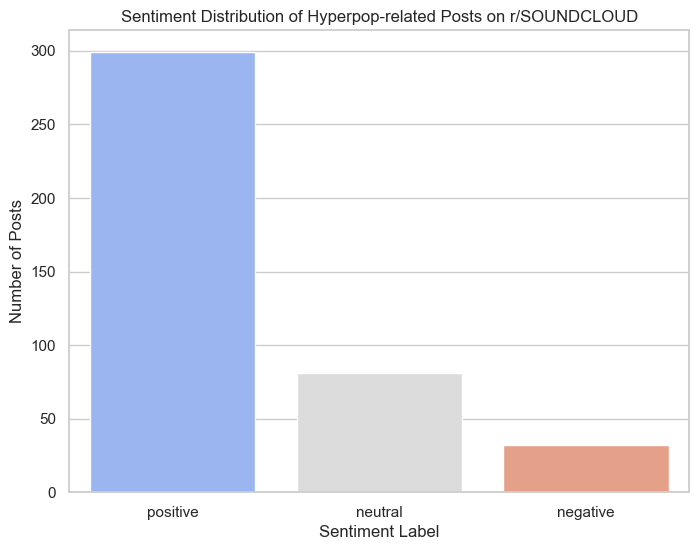

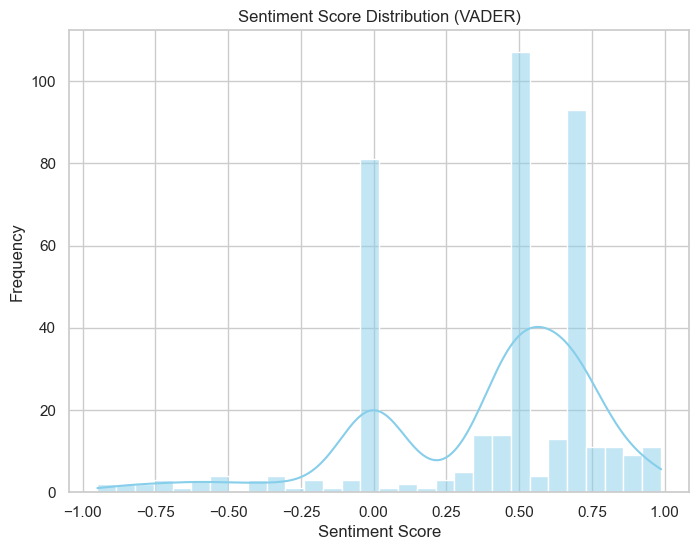

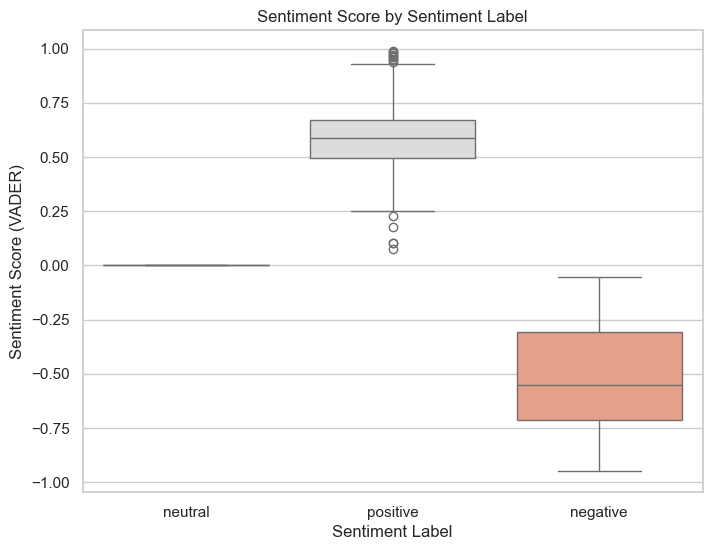

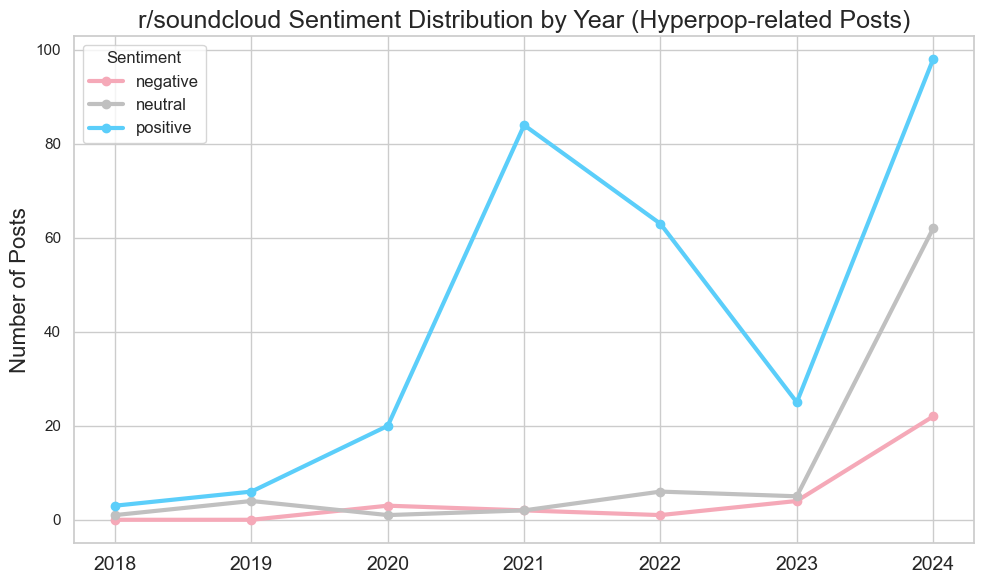

In [33]:
# Load the processed DataFrame with sentiment analysis results
filename = "sentiments/hyperpop_filter/soundcloud_comments.csv"
df = pd.read_csv(filename)

# Set up the visual style for Seaborn
sns.set(style="whitegrid")

# Create a count plot for sentiment labels (positive, neutral, negative)
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x="sentiment_label", palette="coolwarm", order=["positive", "neutral", "negative"]), 
plt.title("Sentiment Distribution of Hyperpop-related Posts on r/SOUNDCLOUD")
plt.xlabel("Sentiment Label")
plt.ylabel("Number of Posts")
plt.show()

# Create a distribution plot for sentiment_vader score
plt.figure(figsize=(8, 6))
sns.histplot(df["sentiment_vader"], bins=30, kde=True, color="skyblue")
plt.title("Sentiment Score Distribution (VADER)")
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")
plt.show()

# Boxplot to show sentiment_vader score distribution by sentiment label
plt.figure(figsize=(8, 6))
sns.boxplot(x="sentiment_label", y="sentiment_vader", data=df, palette="coolwarm")
plt.title("Sentiment Score by Sentiment Label")
plt.xlabel("Sentiment Label")
plt.ylabel("Sentiment Score (VADER)")
plt.show()

# Plot sentiment distribution by year as a line graph.

# Ensure date is datetime
df["date"] = pd.to_datetime(df["date"], errors="coerce")

# Drop rows with invalid dates
df = df.dropna(subset=["date"])

# Extract year
df["year"] = df["date"].dt.year

# Count sentiment per year
sentiment_counts = df.groupby(["year", "sentiment_label"]).size().reset_index(name="count")

# Pivot for line plot
sentiment_pivot = sentiment_counts.pivot_table(index="year", columns="sentiment_label", values="count", aggfunc="sum").fillna(0)

# Define custom colors and line widths for each sentiment
line_colors = {
    "positive": "#5BCEFA",
    "neutral": "#C0C0C0",
    "negative": "#F5A9B8"
}

# Plot
ax = sentiment_pivot.plot(
    kind="line",
    marker="o",
    linestyle='-',
    figsize=(10, 6),
    color=[line_colors[col] for col in sentiment_pivot.columns]
)

# Apply line widths
for line, col in zip(ax.lines, sentiment_pivot.columns):
    line.set_linewidth(3)

# Titles and labels
plt.title("r/soundcloud Sentiment Distribution by Year (Hyperpop-related Posts)", fontsize=18)
plt.xlabel("", fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel("Number of Posts", fontsize=16)
plt.legend(title="Sentiment", fontsize=12)
plt.tight_layout()
plt.show()


In [7]:
# decompress r/HYPERPOP comments
input_file = "compressed_subreddits/soundcloud_comments.zst"
output_file = "decompressed_subreddits/soundcloud_comments"
output_format = "csv"
from_date = datetime.strptime("2005-01-01", "%Y-%m-%d")
to_date = datetime.strptime("2030-12-31", "%Y-%m-%d")
single_field = None
field = None
values = ['']
exact_match = False  
process_file(input_file, output_file, output_format, field, values, from_date, to_date, single_field, exact_match)

2025-05-01 17:53:12,402 - INFO: Input: compressed_subreddits/soundcloud_comments.zst : Output: decompressed_subreddits/soundcloud_comments.csv : Is submission False
2025-05-01 17:53:14,602 - INFO: 2022-03-27 18:29:00 : 100,000 : 99,999 : 0 : 16,122,225:65%
2025-05-01 17:53:16,142 - INFO: 2024-07-30 22:56:20 : 200,000 : 199,999 : 0 : 23,200,275:93%
2025-05-01 17:53:16,956 - INFO: Complete : 255,839 : 255,839 : 0


In [4]:
# Read the CSV file
df = pd.read_csv("decompressed_subreddits/soundcloud_comments.csv", header=None, names=["post_id", "date", "username", "url", "text"])

# Drop non-string or missing comments
df = df[df["text"].apply(lambda x: isinstance(x, str))]
df = df[df["text"].notna()]

# Basic filtering
df = df[df["text"].str.split().str.len().between(2, 500)]  # Min 2 words, max 500

# Remove URLs and special characters
def clean_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)       # Remove URLs
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)                # Remove symbols
    return text

# Apply the cleaning function to the 'text' column
df["clean_text"] = df["text"].apply(clean_text)

# convert to lists for BERTopic
docs = df["clean_text"].tolist()
timestamps = df["date"].tolist()

In [ ]:
umap_model = umap.UMAP(n_neighbors=15, n_components=5, metric='cosine')
hdbscan_model = HDBSCAN(min_cluster_size=30, prediction_data=True)

topic_model = BERTopic(
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    calculate_probabilities=False,
    low_memory=True,
    verbose=True
)

topics, probs = topic_model.fit_transform(docs)


# Save the topics and probabilities to a Pickle file
with open("soundcloud_topics_and_probs.pkl", "wb") as f:
    pickle.dump(topic_model, f)

2025-05-02 06:30:05,664 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 6694/6694 [03:24<00:00, 32.68it/s]
2025-05-02 06:33:36,279 - BERTopic - Embedding - Completed ✓
2025-05-02 06:33:36,280 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
2025-05-02 07:05:23,248 - BERTopic - Dimensionality - Completed ✓
2025-05-02 07:05:23,253 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-02 07:05:48,382 - BERTopic - Cluster - Completed ✓
2025-05-02 07:05:48,412 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-05-02 07:05:51,021 - BERTopic - Representation - Completed ✓


In [6]:
# Get the topic information over time

with open("soundcloud_topics_and_probs.pkl", "rb") as f:
    topic_model = pickle.load(f)

# Convert timestamps to datetime objects
timestamps_dt = [datetime.strptime(ts, "%Y-%m-%d") for ts in timestamps]

# Grab the year from each timestamp 
timestamps_yearly = [ts.year for ts in timestamps_dt]

topics_over_time = topic_model.topics_over_time(docs, timestamps=timestamps_yearly) 

# Save the topics over time to a Pickle file
with open("soundcloud_topics_over_time.pkl", "wb") as f:
    pickle.dump(topics_over_time, f)

15it [00:15,  1.03s/it]


In [ ]:
with open("soundcloud_topics_and_probs.pkl", "rb") as f:
    topic_model = pickle.load(f)

# Define a list of words to search for in the topic names
search_terms = ["charli xcx, hyperpop", "100 gecs", "sophie", "ag cook", "danny l harle",]

# Combine the search terms into a single regular expression (case-insensitive)
pattern = "|".join(search_terms)

# Get topic information
topic_info = topic_model.get_topic_info()

# Search for topics whose name contains any of the search terms
matches = topic_info[topic_info["Name"].str.contains(pattern, case=False)]


print(matches[["Topic", "Name"]])

     Topic                                     Name
7        6                6_track_latest_nice_heres
75      74            74_private_track_click_public
200    199  199_rroastmytrack_requirements_both_amp
439    438             438_tha_trackz_theze_knightz
554    553               553_chould_track_love_song
585    584              584_tha_trackz_theze_twynnr
598    597            597_house_track_latest_recent
606    605                     605_yu_fw_drop_track


In [9]:
topic_model.visualize_topics_over_time(topics_over_time, topics=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], title="Top r/Soundcloud Topics Over Time", width=800, height=400)


In [16]:
topic_model.visualize_topics_over_time(topics_over_time, topics=[176], title="Top r/Soundcloud Topics Over Time", width=800, height=400)
